# **XLNet Sentiment analysis**



## Notebook preparation

### Setup connection to Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Web Mining"

/content/drive/.shortcut-targets-by-id/1AaoxM8l2i5zg2py3FxAn4vfLKvH9mitN/Web Mining


### install relevant packages

In [3]:
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5

     |████████████████████████████████| 645kB 10.0MB/s 
     |████████████████████████████████| 5.6MB 21.1MB/s 
     |████████████████████████████████| 1.2MB 36.5MB/s 
     |████████████████████████████████| 901kB 33.5MB/s 
     |████████████████████████████████| 235kB 12.2MB/s 
     |████████████████████████████████| 829kB 19.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=9745a38a4eeb719dc30071801cfeebaec1656e4e7cd46954e8b23c90895ded80
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [4]:
!pip install -q -U watermark

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 2.9.0



### import relevant libraries

In [6]:
import os
import re

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.nn.functional as F

### setup gpu for training if it is available

In [7]:
# Check if a GPU can be used
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not assign CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Define run settings of notebook

Four different settings can be changed for the data preparation and training of the current notebook:


* Specify XLNet Model (**xlnet-base-cased** )
* Split lyrics with sliding window
* Specify Dataset
* Preprocess lyrics tags (will only be used for the dataset with commas for line breaks)

In [11]:
#from transformers import XLNetForSequenceClassification

# specify name of model
pretrained_model_name = 'xlnet-base-cased'

# define if lyrics should be splitted with sliding window to prevent reduction of tokens
split_lyrics = True #False

# specify dataset that will be used for training
file_name = 'all_songs_preprocessed.csv' #Two classes: all_songs_preprocessed.csv 
                                         #Two classes: Comma_Dataset/all_songs_lyrics_comma.csv
                                         #Three classes: Classes_Dataset/all_songs_preprocessed_classes.csv 
                                         #Three classes: Classes_Dataset/all_songs_lyrics_comma_classes.csv

# preprocess lyrics tags (if dataset is included with comma)
if file_name == 'all_songs_preprocessed.csv': #For Three classes use this: Classes_Dataset/all_songs_preprocessed_classes.csv 
  preprocess_lyrics = False # Does not need to be changed as in this dataset preprocessing was already done
else:
  preprocess_lyrics = True # Can be set to false

# define how many epochs we want to train
EPOCHS = 5

# define how many classes can be chosen
num_classes = 2

In [9]:
# define random settings for reproducability
random_seed = 46
np.random.seed(random_seed)
torch.manual_seed(random_seed)

## Data Preparation


### Load data

Print basic structure of dataframe to get overall understanding of the data

In [15]:
data = pd.read_csv(file_name)

if num_classes == 2 and file_name != 'all_songs_preprocessed.csv':
  data = data[['lyrics', 'sentiment_2classes']]
  data = data.dropna()
elif num_classes == 2 and file_name == 'all_songs_preprocessed.csv':
  data = data[['lyrics', 'sentiment']]
  data = data.dropna()
elif num_classes == 3:
  data = data[['lyrics', 'sentiment_3classes']]
else:
  raise ValueError(f'Specify num_classes variable instead of {num_classes} to either 2 or 3')

data.columns = ['lyrics', 'sentiment']

print(data.columns)
print(data.head(5))

Index(['lyrics', 'sentiment'], dtype='object')
                                              lyrics  sentiment
0   let's make this christmas mean something this...          0
1  come over baby whole lot of shakin' goin' on  ...          1
2  don't go over there, that vultures gonna get y...          0
3   hey, don't write yourself off yet it's only i...          1
4   cut my life into pieces, this is my last reso...          1


### Replace information parts within lyrics


> Parts in which f.e. Chorus or Verse is marked within dataset (New part will be marked with an point, linebreaks with a comma



In [16]:
def preprocess(lyrics):
  lyrics = re.sub(r'\[.*?\]', '.', lyrics) # replace Information brackets with point to mark end of logical part in a song
  lyrics = re.sub(r'^(,*\.,*)', '', lyrics) # replace dots and commas at beginning of song
  return re.sub(r'(,*\.,*)', '.', lyrics) # replace sequence of commas before and after a point with a single point

if preprocess_lyrics is True:
  data['lyrics_pre'] = data.lyrics.apply(preprocess)

In [17]:
def to_sentiment(valence):
  if valence < 0.5:
    return 0
  elif valence > 0.5:
    return 1

if file_name == 'Comma_Dataset/all_songs_lyrics_comma.csv':
  data['sentiment'] = data.valence.apply(to_sentiment)

### define sliding window
Idea is to not truncate lyrics as important information might get missed


> Sliding window is defined by a window size of 200 words and incorporation 50 words from before to add context to sliding window



In [18]:
# define method for sliding window
def get_split(lyrics):
  data = []
  partial = []
  if len(lyrics.split())//150 >0:
    n = len(lyrics.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      partial = lyrics.split()[:200]
      data.append(" ".join(partial))
    else:
      partial = lyrics.split()[w*150:w*150 + 200]
      data.append(" ".join(partial))
  return data

In [19]:
# check if lyrics will be splitted
if split_lyrics is True:
  if preprocess_lyrics is True:
    data['lyrics_split'] = data['lyrics_pre'].apply(get_split)
  else:
    data['lyrics_split'] = data['lyrics'].apply(get_split)
  # define list for reconstructing dataframe
  train = []
  label = []
  index =[]
  # iterate through list to split list in one column into multiple rows
  for idx,row in data.iterrows():
    for element in row['lyrics_split']:
      train.append(element)
      label.append(row['sentiment'])
      index.append(idx)
  data = pd.DataFrame({'lyrics': train, 'sentiment': label})
else:
  data = data[['lyrics', 'sentiment']] #lyrics_pre

In [20]:
data

,lyrics,sentiment
0,let's make this christmas mean something this ...,0
1,come over baby whole lot of shakin' goin' on y...,1
2,"don't go over there, that vultures gonna get y...",0
3,"hey, don't write yourself off yet it's only in...",1
4,"cut my life into pieces, this is my last resor...",1
...,...,...
27112,i've been waiting on a war since i was young s...,1
27113,war? just waiting on a war for this and that t...,1
27114,"oh, you think you're worth all the fuss? you t...",0
27115,world but you still talk down and call me litt...,0


### split data in train, validation and test dataset



In [21]:
# ratio for training and test data split
ratio_test = 0.2
# define random seed to get same result for the training and test data
data_train, data_test, target_train, target_test = train_test_split(data['lyrics'], data['sentiment'], test_size=ratio_test, random_state=random_seed, shuffle=True)
data_val, data_test, target_val, target_test = train_test_split(data_test, target_test, test_size=0.5, random_state=random_seed, shuffle=True)

# Check splits
print(f'Train size: {len(target_train)}')
print(f'Test size: {len(target_test)}')
print(f'Validation size: {len(target_val)}')
# Check balance of different subsets
print(10*'-')
if num_classes == 2:
  print(f'Train size positive: {np.sum(target_train==1)}')
  print(f'Train size neutral: {np.sum(target_train==2)}')
  print(f'Train size negative: {np.sum(target_train==0)}')
  print(f'Test size positive: {np.sum(target_test==1)}')
  print(f'Test size neutral: {np.sum(target_test==2)}')
  print(f'Test size negative: {np.sum(target_test==0)}')
  print(f'Validation size positive: {np.sum(target_val==1)}')
  print(f'Validation size neutral: {np.sum(target_val==2)}')
  print(f'Validation size negative: {np.sum(target_val==0)}')
elif num_classes == 3:
  print(f'Train size positive: {np.sum(target_train==2)}')
  print(f'Train size neutral: {np.sum(target_train==1)}')
  print(f'Train size negative: {np.sum(target_train==0)}')
  print(f'Test size positive: {np.sum(target_test==2)}')
  print(f'Test size neutral: {np.sum(target_test==1)}')
  print(f'Test size negative: {np.sum(target_test==0)}')
  print(f'Validation size positive: {np.sum(target_val==2)}')
  print(f'Validation size neutral: {np.sum(target_val==1)}')
  print(f'Validation size negative: {np.sum(target_val==0)}')

Train size: 21693
Test size: 2712
Validation size: 2712
----------
Train size positive: 11786
Train size neutral: 0
Train size negative: 9907
Test size positive: 1465
Test size neutral: 0
Test size negative: 1247
Validation size positive: 1446
Validation size neutral: 0
Validation size negative: 1266


### Tokenizer



#### Load Tokenizer

In [22]:
!pip install sentencepiece

In [23]:
# Load the XLNET tokenizer.
import sentencepiece
from transformers import XLNetTokenizer, XLNetModel

print('Loading XLNET tokenizer...')
#PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name, do_lower_case=True)

#tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, do_lower_case=True)

Loading XLNET tokenizer...


#### Build Dataset for training

In [24]:
# Construct DataLoader class to transform data to DataLoader object
class LyricsDataset(Dataset):

  def __init__(self, lyrics, labels, tokenizer, max_len):
    self.lyrics = lyrics
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.lyrics)

  def __getitem__(self, idx):
    lyrics = str(self.lyrics[idx])
    label = self.labels[idx]
    encoding = self.tokenizer.encode_plus(
      lyrics,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]' and [PAD]
      max_length=self.max_len, # Pad & truncate all texts
      pad_to_max_length=True,
      return_token_type_ids=False,
      return_attention_mask=True, # Construct attention masks
      return_tensors='pt', # Return pytorch tensors
    )

    return {
      'lyrics_text': lyrics,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [25]:
# which help us to customizing data loading order and do automatic batching
def create_data_loader(X, Y, tokenizer, max_len, batch_size, num_workers=2, sampler = None):
  ds = LyricsDataset(
    lyrics=np.array(X),
    labels=np.array(Y),
    tokenizer=tokenizer,
    max_len=max_len
  )
  if sampler!=None:
    sampler = sampler(ds)

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler = sampler
  )

In [26]:
MAX_LEN = 256
BATCH_SIZE = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_data_loader = create_data_loader(data_train, target_train, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Select batches randomly
val_data_loader = create_data_loader(data_val, target_val, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Pull out batches sequentially.
test_data_loader = create_data_loader(data_test, target_test, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Pull out batches sequentially.

## Modelling

### Load model

In [27]:
# Load XLNetForSequenceClassification, the pretrained XLNet model with a single 
# linear classification layer on top. 

from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels = num_classes, # output labels specified in the num_classes variable
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the specified device
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The XLNet model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLNet model has 210 different named parameters.

==== Embedding Layer ====

transformer.mask_emb                                     (1, 1, 768)
transformer.word_embedding.weight                       (32000, 768)
transformer.layer.0.rel_attn.q                          (768, 12, 64)
transformer.layer.0.rel_attn.k                          (768, 12, 64)
transformer.layer.0.rel_attn.v                          (768, 12, 64)

==== First Transformer ====

transformer.layer.0.rel_attn.o                          (768, 12, 64)
transformer.layer.0.rel_attn.r                          (768, 12, 64)
transformer.layer.0.rel_attn.r_r_bias                       (12, 64)
transformer.layer.0.rel_attn.r_s_bias                       (12, 64)
transformer.layer.0.rel_attn.r_w_bias                       (12, 64)
transformer.layer.0.rel_attn.seg_embed                   (2, 12, 64)
transformer.layer.0.rel_attn.layer_norm.weight                (768,)
transformer.layer.0.rel_attn.layer_norm.bias             

### Define optimizer

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 1e-3
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-6.
                )

In [30]:
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
# Training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model.train()
  total_train_accuracy = 0
  total_train_loss = 0
  losses = []
  correct_predictions = 0
  for step, batch in enumerate(data_loader):
    if step % 40 == 0 and not step == 0:
       print('Batch: {}  of  {}'.format(step, len(data_loader)))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    model.zero_grad()
    outputs = model(
      input_ids=input_ids,
      token_type_ids=None,
      attention_mask=attention_mask,
      labels=labels
    )
    loss = outputs[0]
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    total_train_accuracy += flat_accuracy(logits, label_ids)
  # Calculate the average loss over all of the batches.
  avg_train_accuracy = total_train_accuracy / len(data_loader)
  avg_train_loss = total_train_loss / len(data_loader) 
  return avg_train_accuracy, avg_train_loss

In [32]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
# Evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_mask,
        labels=labels
      )
      total_eval_loss += outputs[0].item()
      logits = outputs[1].detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()
      total_eval_accuracy += flat_accuracy(logits, label_ids)

  avg_val_accuracy = total_eval_accuracy / len(data_loader)
  avg_val_loss = total_eval_loss / len(data_loader)
  #print("Accuracy: {0:.2f}".format(avg_val_accuracy))
  #print("Validation Loss: {0:.2f}".format(avg_val_loss))
  return avg_val_accuracy, avg_val_loss

## Model Training

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(data_train)
  )
  print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(data_val)
  )
  print('Val loss: {}, Accuracy: {}'.format(val_loss, val_acc))
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  model_save_name = 'model_epoch' + str(epoch+1) + '.bin'
  torch.save(model.state_dict(), model_save_name)

  if val_acc > best_accuracy:
    print('Epoch: ', str(epoch+1))
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch: 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Batch: 40  of  573
Batch: 80  of  573
Batch: 120  of  573
Batch: 160  of  573
Batch: 200  of  573
Batch: 240  of  573
Batch: 280  of  573
Batch: 320  of  573
Batch: 360  of  573
Batch: 400  of  573
Batch: 440  of  573
Batch: 480  of  573
Batch: 520  of  573
Batch: 560  of  573
Train loss: 0.6968321362299029, Accuracy: 0.5256326352530541
Val loss: 0.7056712342633141, Accuracy: 0.5509259259259259

Epoch:  1
Epoch: 2/5
----------
Batch: 40  of  573
Batch: 80  of  573
Batch: 120  of  573
Batch: 160  of  573
Batch: 200  of  573
Batch: 240  of  573
Batch: 280  of  573
Batch: 320  of  573
Batch: 360  of  573
Batch: 400  of  573
Batch: 440  of  573
Batch: 480  of  573
Batch: 520  of  573
Batch: 560  of  573
Train loss: 0.6932667942155302, Accuracy: 0.5312681791739383
Val loss: 0.7013702798220847, Accuracy: 0.4497492283950617

Epoch: 3/5
----------
Batch: 40  of  573
Batch: 80  of  573
Batch: 120  of  573
Batch: 160  of  573
Batch: 200  of  573
Batch: 240  of  573
Batch: 280  of  573
Batch: 320

## Model Evaluation

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)
print(f'Testing Accuracy: {test_acc.item()}')
print('Test Loss :', test_loss)

Testing Accuracy: 0.625
Test Loss : 0.6866194150514073


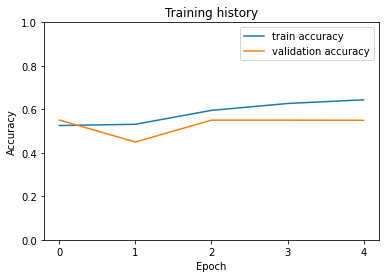

In [ ]:
# Plot the accuracy for training and validation set
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0, 5, 1.0))
plt.ylim([0, 1]);

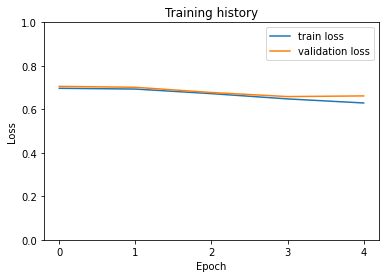

In [ ]:
# Plot the accuracy for training and validation set
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0, 5, 1.0))
plt.ylim([0, 1]);

In [ ]:
# How to save model
output_dir = f'./save_model_{pretrained_model_name}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#Load a trained model and vocabulary that you have fine-tuned
# model = XLNetForSequenceClassification.from_pretrained(output_dir)
# tokenizer = XLNetTokenizer.from_pretrained(output_dir)

Saving model to ./save_model_xlnet-base-cased


('./save_model_xlnet-base-cased/spiece.model',
 './save_model_xlnet-base-cased/special_tokens_map.json',
 './save_model_xlnet-base-cased/added_tokens.json')

Load trained model directly

In [ ]:
#Load trained model directly
#model.load_state_dict(torch.load('best_model_state.bin'))
#model = model.to(device)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    lyrics_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["lyrics_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            lyrics_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return lyrics_texts, predictions, prediction_probs, real_values

In [ ]:
y_lyrics_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = ['negative', 'positive'] #for two-classes
#If it is three classes problem, uncomment this.
#class_names = ['negative', 'neutral', 'positive']

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.64      0.72      0.68       612
    positive       0.62      0.53      0.57       534

    accuracy                           0.63      1146
   macro avg       0.63      0.62      0.62      1146
weighted avg       0.63      0.63      0.63      1146

